In [3]:
import torch_config as config
from data_functions import convert_to_tensor, load_data, split_data
from model.anomaly_detector import AnomalyDetector
from utils.gpu_utils import device_context
from matplotlib import pyplot as plt
import numpy as np

(GPU is available)
(Using Device: cpu)


In [4]:
dirpath = config.SAVED_MODEL_PATH
dirpath.mkdir(exist_ok=True, parents=True)

In [61]:
X_normal, X_test = load_data(config.H5_PATH.joinpath(config.H5_FILENAME), "chb15")
if not X_normal:
    raise ValueError("No training data found")
if not X_test:
    raise ValueError("No test data found")
_, X_val = split_data(X_normal, random_state=config.RANDOM_STATE)

# Convert to tensor
X_val, = convert_to_tensor(X_val)
X_test = convert_to_tensor(*X_test)

with device_context:
    model = AnomalyDetector.load(dirpath)
    val_losses = model.model.calculate_losses(X_val).cpu().numpy()  # type: ignore
    test_losses = tuple(model.model.calculate_losses(x).cpu().numpy() for x in X_test)  # type: ignore



Loading training data...  DONE
Training recordings: 25
Total training samples: 17975
Loading test data...  DONE
Testing recordings: 6
Total testing samples: 2153
Splitting data...  DONE
(Using Device: cuda)
(Using Device: cpu)


In [62]:
sep = config.PREICTAL_SECONDS//(config.WINDOW_SIZE_SECONDS - config.WINDOW_OVERLAP_SECONDS)
test_normal_losses = []
test_preictal_losses = []

for test_loss in test_losses:
    test_normal_losses.append(test_loss[:sep])
    test_preictal_losses.append(test_loss[sep:])

test_normal_losses = np.concatenate(test_normal_losses)
test_preictal_losses = np.concatenate(test_preictal_losses)

Text(0.5, 1.0, 'Test Preictal Losses')

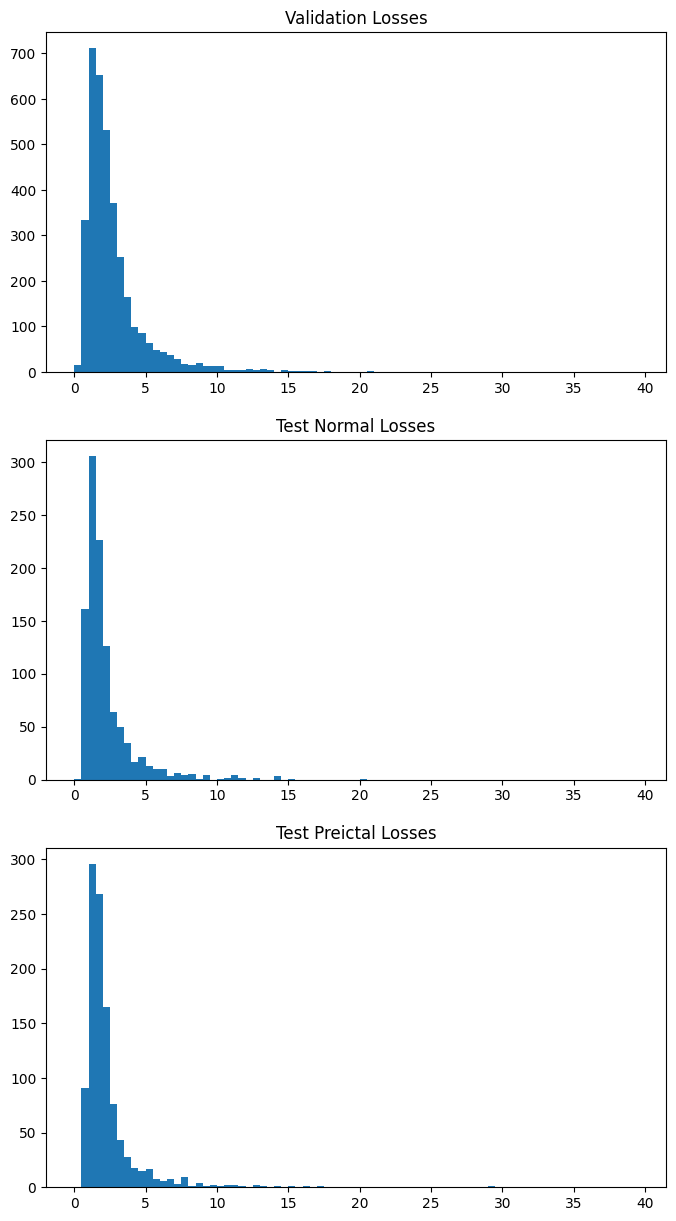

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
axs[0].hist(val_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[0].set_title("Validation Losses")
axs[1].hist(test_normal_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[1].set_title("Test Normal Losses")
axs[2].hist(test_preictal_losses, bins=[x/2 for x in range(0, 80, 1)])
axs[2].set_title("Test Preictal Losses")

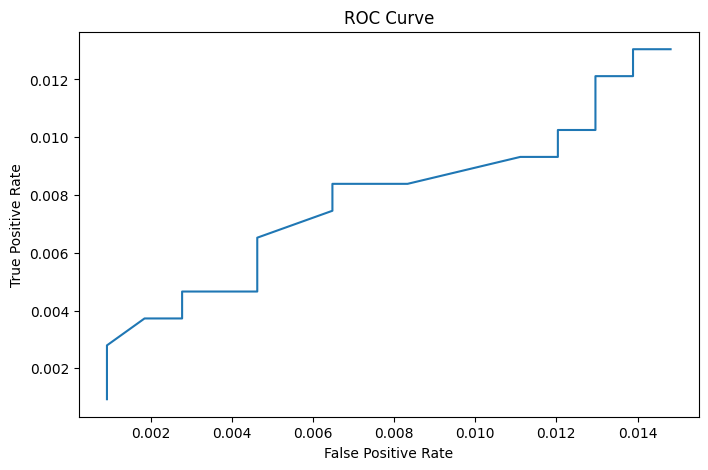

In [64]:
x = np.arange(10,20,0.1)
fp = np.array([np.count_nonzero(test_normal_losses > th)/len(test_normal_losses) for th in x])
tp = np.array([np.count_nonzero(test_preictal_losses > th)/len(test_preictal_losses) for th in x])
fn = 1 - tp
tn = 1 - fp 
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.plot(fpr, tpr)

In [59]:
print([np.percentile(val_losses, x/10) for x in range(990, 1001, 1)])
print(np.percentile(val_losses, 100))
model.threshold.threshold = np.percentile(val_losses, 1)
model.save(dirpath)

[13.274486579895019, 13.53892434310913, 13.917868804931661, 14.944390287399298, 15.155907302856498, 16.2506694030762, 17.113327789306556, 18.04992102050773, 21.774283798217652, 30.076904121399863, 51.78617477416992]
51.78617477416992
